# Acknowledgement

Parts of this pset were inspired by
* Berkeley CS294-158, taught by Pieter Abbeel, Wilson Yan, Kevin Frans, and Philipp Wu;
* MIT 6.S184/6.S975, taught by Peter Holderrieth and Ezra Erives;
* The [blog post](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/) about diffusion models by Lilian Weng.




# Submission Guideline for Part 2

Please include your answer to all problems, including formulas, proofs, and the figures generated in each problem, excluding code. You are required to submit the (single) pdf and all (four) notebooks (one for each problem) with your code and running outputs. Do not include code in the pdf file.

Specifically, for Problem 4 in this notebook, the pdf should contain:
- The generated figures `results/sampling_comparison.png`
- Answer to the short answer question about different samplers and number of steps

# Problem 4: Sampling based on Pretrained Models
In this problem, you will implement two ODE based sampling algorithms for diffusion models:

* Euler sampler
* Euler sampler with Heun correction

You'll apply these samplers to a [pretrained diffusion model](https://huggingface.co/google/ddpm-cifar10-32) on CIFAR-10 and compare their results. Note that in this problem (unlike in Problem 2 and 3), we use the stochastic equation perspective of diffusion models, as introduced in [Song *et al*., 2021](https://arxiv.org/pdf/2011.13456).

This part requires GPUs--you can use Google Colab for GPU access. To work on this notebook in Google Colab, copy the `pset-5` directory to your Google Drive and open this notebook. Then, start working on a GPU machine with `Runtime -> Change runtime type -> T4 GPU`.

## Pretrained Model on CIFAR-10

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from diffusers import DDPMPipeline
from tqdm.auto import tqdm
from diffusers import DDIMScheduler

# Load a pretrained DDPM model on CIFAR-10
model_id = "google/ddpm-cifar10-32"
pipeline = DDPMPipeline.from_pretrained(model_id)
pipeline = pipeline.to("cuda" if torch.cuda.is_available() else "cpu")

# Extract the necessary components
unet = pipeline.unet
# The original scheduler is for SDE sampling. Initialize another scheduler for ODE sampling.
ode_scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)

# Helper function to visualize results
def show_images(images, title=None, figsize=(10, 10)):
    plt.figure(figsize=figsize)
    if title:
        plt.suptitle(title)

    for i, img in enumerate(images):
        plt.subplot(4, 4, i + 1)
        if isinstance(img, torch.Tensor):
            img = img.detach().cpu().numpy()
        if img.shape[0] == 3:  # If the image has a channel dimension first
            img = np.transpose(img, (1, 2, 0))
        plt.imshow(img)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


An error occurred while trying to fetch /root/.cache/huggingface/hub/models--google--ddpm-cifar10-32/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--google--ddpm-cifar10-32/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


## Euler Sampler with Heun Correction
The diffusion sampling process involves solving the ordinary differential equation (ODE):

$$\frac{dx}{dt} = f(x, t)$$

where $f(x, t)$ is the drift coefficient derived from the score function.

The Euler method with Heun correction is a second-order method:
* **Euler Step (Predictor)**:
    $$\hat{x}_{t-\Delta t} = x_t - \Delta t \cdot f(x_t, t)$$

* **Heun Correction (Corrector)**:
    $$x_{t-\Delta t} = x_t - \frac{\Delta t}{2} \cdot \big[f(x_t, t) + f(\hat{x}_{t-\Delta t}, t-\Delta t)\big]$$

You need to use the [`diffusers`](https://huggingface.co/docs/diffusers/en/index) package for certain classes and functions. The drift function $f(x_t, t)$ can be obtained by:
```
model_output = model(sample, t).sample
```

Complete the function `euler_heun_sampler` and evaluate it using the given comparison code. What can you conclude based on the generated images using different samplers and number of steps?

In [2]:
from PIL import Image
import numpy as np
def euler_heun_sampler(model, scheduler, num_inference_steps=50, num_images=16,
                       device="cuda", use_heun=False):
    """
    Implement the Euler sampler with Heun correction for diffusion models

    Args:
        model: The U-Net model that predicts noise residuals
        scheduler: Diffusion scheduler with step, add_noise, and other utilities
        num_inference_steps: Number of denoising steps
        num_images: Number of images to generate
        device: Device to run the model on
        use_heun: Whether to use Heun correction (default: False)

    Returns:
        A batch of generated images
    """
    # TODO: Initialize the scheduler for inference

    # TODO: Sample noise from a normal distribution. CIFAR-10 image shape is (3, 32, 32)

    # TODO: Implement the sampling loop
    # For each timestep from T to 0:
    #   1. Predict noise residual with the model
    #   2. Compute the Euler step
    #   3. (Optional) If not the last step, compute the Heun correction
    #   4. Update the sample

    # TODO: Convert samples to images and return (change the output from [-1,1] to [0,1] range and clip the values)
    # raise NotImplementedError("Please implement this")

    with torch.no_grad():
      images = []


      for i in tqdm(range(num_images)):
          x_t = torch.randn(3, 32, 32).to(device)
          x_t = x_t.unsqueeze(0)

          scheduler.set_timesteps(num_inference_steps)


          for i in range(len(scheduler.timesteps)):
            t = scheduler.timesteps[i]
            residual = model(x_t, t).sample
            x_tm1 = scheduler.step(residual, t, x_t).prev_sample

            if (i < len(scheduler.timesteps) - 1):
              residual_prev = model(x_tm1, scheduler.timesteps[i+1]).sample
              x_tm1 = scheduler.step(1/2 * (residual + residual_prev), t ,x_t).prev_sample
            x_t = x_tm1

          image = (x_t / 2 + 0.5).clamp(0, 1).squeeze()
          image = (image.permute(1, 2, 0) * 255).round().to(torch.uint8).cpu().numpy()
          image = Image.fromarray(image)
          images.append(image)

    return images

























In [3]:
def compare_samplers(model, ode_scheduler, num_inference_steps_list=[10, 20, 50],
                     num_images=16, device="cuda"):
    """
    Compare different sampling methods with varying inference steps
    """
    results = {}

    for steps in num_inference_steps_list:
        print(f"\nGenerating samples with {steps} inference steps:")

        # Set random seed for reproducibility
        torch.manual_seed(42)
        print("\nRunning Euler sampler:")
        euler_samples = euler_heun_sampler(
            model=model,
            scheduler=ode_scheduler,
            num_inference_steps=steps,
            num_images=num_images,
            device=device,
            use_heun=False
        )
        results[f"euler_{steps}"] = euler_samples

        # Reset random seed for fair comparison
        torch.manual_seed(42)
        print("\nRunning Euler-Heun sampler:")
        euler_heun_samples = euler_heun_sampler(
            model=model,
            scheduler=ode_scheduler,
            num_inference_steps=steps,
            num_images=num_images,
            device=device,
            use_heun=True
        )
        results[f"euler_heun_{steps}"] = euler_heun_samples

    return results



Generating samples with 10 inference steps:

Running Euler sampler:



Running Euler-Heun sampler:



Generating samples with 50 inference steps:

Running Euler sampler:



Running Euler-Heun sampler:



Generating samples with 250 inference steps:

Running Euler sampler:



Running Euler-Heun sampler:


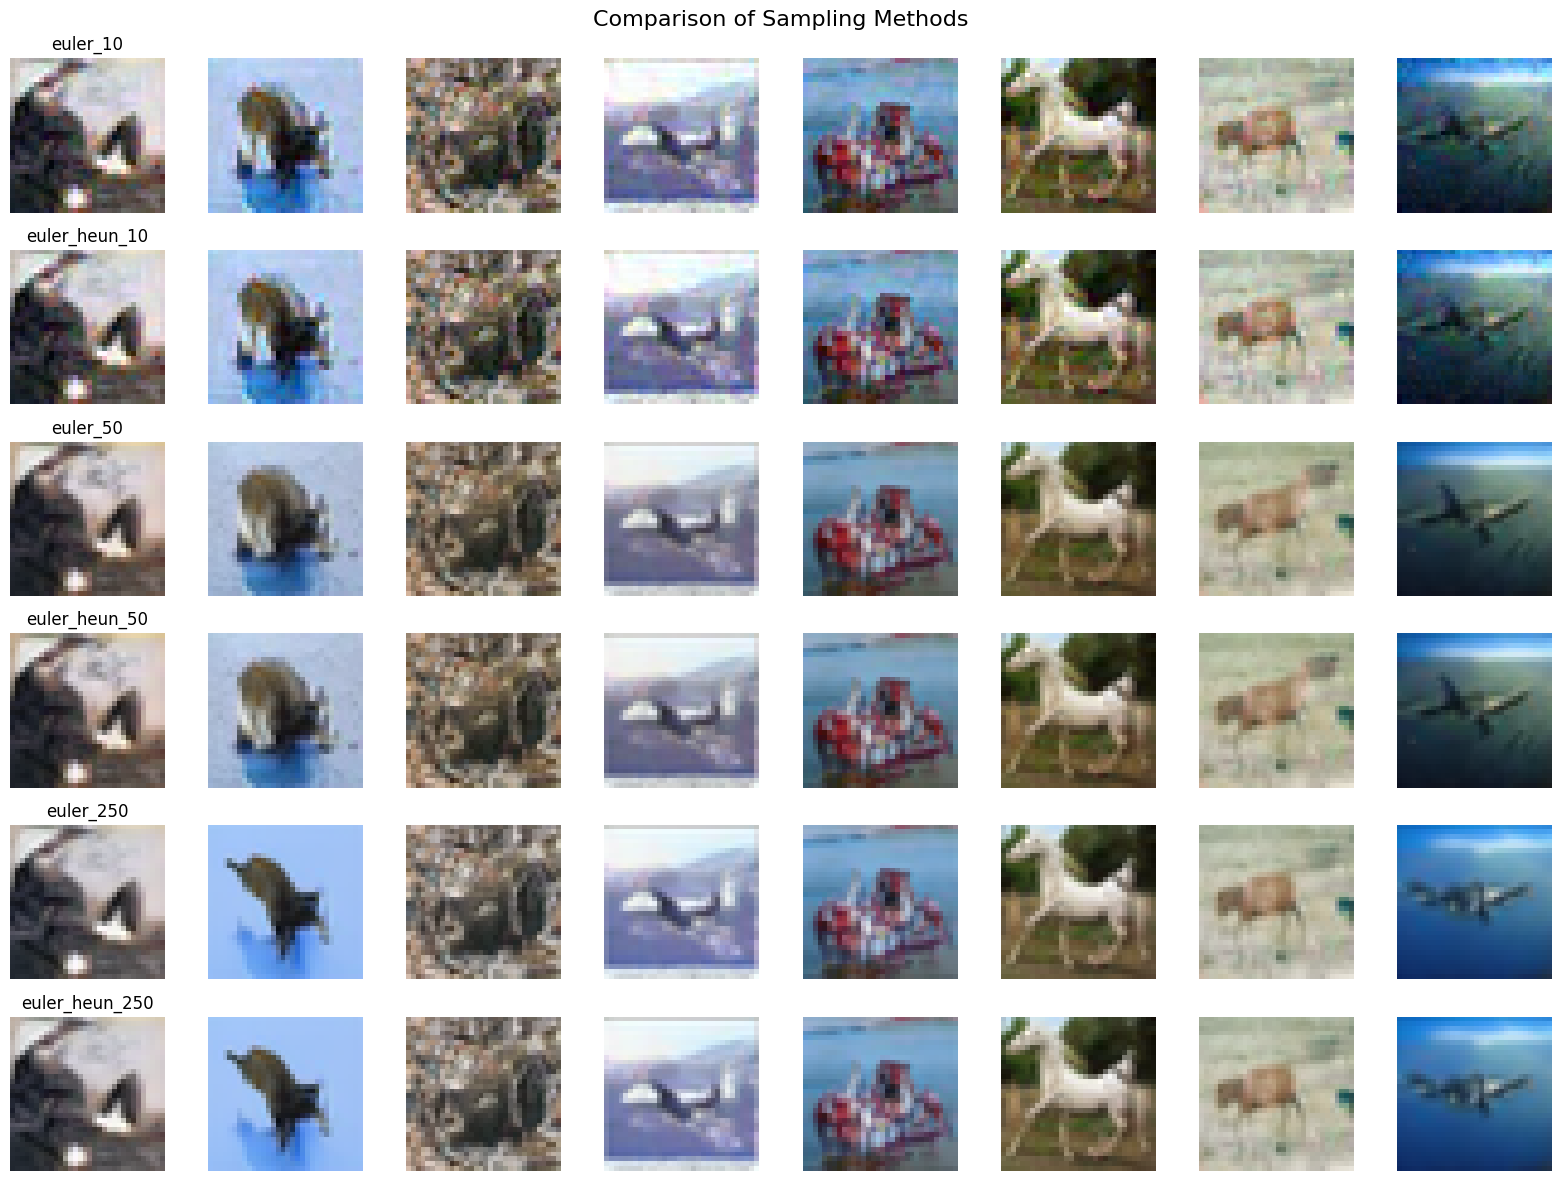

In [11]:
results = compare_samplers(unet, ode_scheduler, num_inference_steps_list=[10, 50, 250])
rows = len(results.keys())
fig, axs = plt.subplots(rows, 8, figsize=(16, rows * 2))
fig.suptitle("Comparison of Sampling Methods", fontsize=16)

for i, (method, samples) in enumerate(results.items()):
    for j in range(8):
        img = np.array(samples[j])
        axs[i, j].imshow(img)
        axs[i, j].set_title(method if j == 0 else "")
        axs[i, j].axis('off')

plt.tight_layout()
#plt.savefig('results/sampling_comparison.png', dpi=300)
plt.show()

# Submission Guideline for Part 2

Please include your answer to all problems, including formulas, proofs, and the figures generated in each problem, excluding code. You are required to submit the (single) pdf and all (four) notebooks (one for each problem) with your code and running outputs. Do not include code in the pdf file.

Specifically, for Problem 4 in this notebook, the pdf should contain:
- The generated figures `results/sampling_comparison.png`
- Answer to the short answer question about different samplers and number of steps